# SENTIMENT ANALYSIS OF ANDROID BANKING APP REVIEWS
CSDA1040 - Advanced Methods of Data Analysis, York University, Canada <br>
Created by: Jessee Ho
***

## PREFACE

>This notebook is a conversion of one of my sentiment analysis assignment for York University’s Big Data and Advanced Analytics course. The assignment was originally done in R, this is a conversion to Python with additional Natural Language Processing (NLP) techniques.

## INTRODUCTION

>Sentiment analysis is a NLP technique that tries to extract and interpret the sentiment or emotion of raw text. In this scenario, I will be applying NLP using this technique on customer reviews of banking apps on the Google Play store. The goal of this study is identify what customers like or dislike about these apps and try to construct models to predict an app rating based on the sentiment of the review. 

## LIBRARY
The main libraries used in this notebook:
>NLTK: Popular natural language module in Python for processing natural human language data. <br>
>Gensim: Open-source unsupervised topic-modelling and vector space modelling toolkit. <br>
>Scikit-learn: Popular python machine learning library for Python with various pre-built features. <br>


Note: for NLTK, you may need to download the modules to run the functions used in this notebook: <br>

import nltk <br>
nltk.download() <br>

In [1]:
#bring all libraries to the top.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import missingno as msno #missmap
import numpy as np
import pandas as pd
import os
#Set home drive
os.chdir("C:/Users/s2555246/Desktop/York University/digital")#set drive

# Exploratory Data Analysis (EDA)

This data was provided by a third party and will not be included with this notebook. To perform similar analysis, a sample data set obtained using the Android web scraper API is included in this project directory or you may use the adnroid web scrape API to obtain your own data. 

## Data Description

>The app store data used her contains 24,847 observations and 18 features. Each observation consists of one user review for one banking app. Each customer review is composed of a raw text review and title, date of posting, app id, app name, language, 2 language translation fields, 2 developer reply fields, 5 user device fields, and a URL link to the original review posting.

In [2]:
#loading the data and initial preview
df = pd.read_csv("reviews_googleplay_android.csv", encoding = "ISO-8859-1") #loading the data
print('Dimensions:',df.shape) #call data dimensions
df.head() #preview data


Dimensions: (24847, 18)


,Date,AppID,AppName,Language,Author,Rating,Title,Review,TranslatedTitle,TranslatedReview,ReplyDate,DeveloperReply,User,Device,DeviceType,Tags,Notes,Link
0,2019-01-28,com.bmo.mobile,BMO Mobile Banking,en,A Google user,3,NaN,Read the other reviews and not sure why other ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...
1,2019-01-28,com.cibc.android.mobi,CIBC Mobile BankingÂ®,en,Jacob Drew,1,NaN,great app other than check your credit score n...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...
2,2019-01-28,com.cibc.android.mobi,CIBC Mobile BankingÂ®,en,Troy O'Rielly,5,NaN,"super convenient, & easy to navigate through.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...
3,2019-01-28,com.scotiabank.Marimba,Scotiabank Caribbean - Banking,en,Simone Edwards,3,NaN,Satisfactory but I'm waiting for the day that ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...
4,2019-01-28,com.td,TD Canada,en,George Danciu,5,NaN,fast and easy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://play.google.com/apps/publish?#ReviewDe...


## Data Integrity

> We can see that the fields TranslatedTitle, TranslatedReview, User, Device, DeviceType, Tags and Notes have little to no data. These can be removed during the data cleanig phase. Additionally, ReplyDate, DeveloperReply, Title and Author are quite sparsely populated fields.

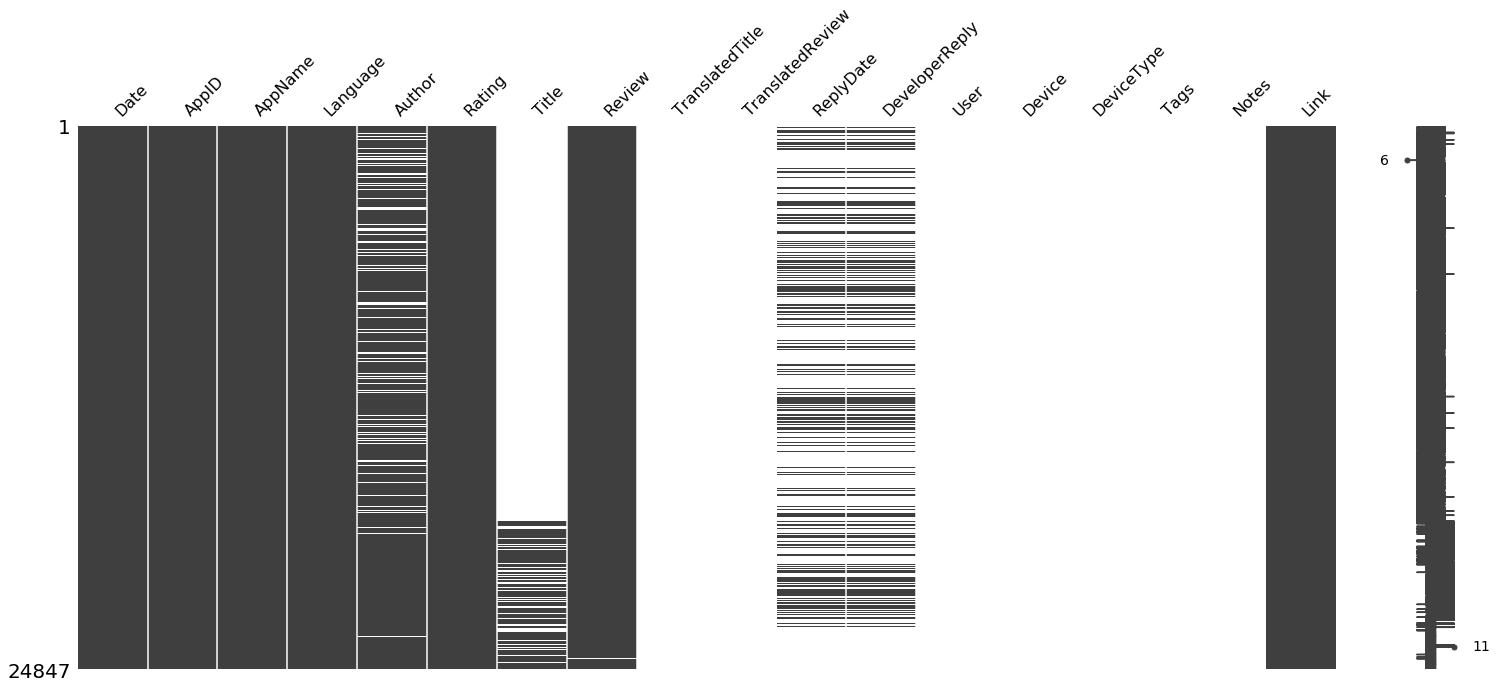

In [3]:
msno.matrix(df)

## Initial Data Cleaning

To simplify the data, features that are less meaningful to our analysis or are too scarcely populated are removed from the dataset.<br>

>Author, User  – Removed unique identifiers. <br>
>AppName – AppID is in a cleaner format and more consistent. AppName contains special characters which did not translate when the data was scraped. <br>
>Language – The reviews are all in English so this field is not meaningful <br>
>TranslatedTitle, TranslatedReview, User, Device, DeviceType, ReplyDate, DeveloperReply, Tags, Notes – too scarcely populated to provide any meaningful insight. <br>
>Link – Removed as outside of the scope of this project, maybe a field of interest for further analysis. <br>

The observations in the AppID field are then replaced with more common names (i.e. bank names). Where multiple apps exist for the same company, the region and TSX Stock identifier is used to denote the entity.


In [4]:
df = df.drop(["Author","AppName","Language","TranslatedTitle", "TranslatedReview", "ReplyDate","DeveloperReply","User","Device","DeviceType","Tags","Notes","Link"], axis=1)
df['AppID']=df['AppID'].replace({'com.bmo.mobile': 'BMO', 'com.cibc.android.mobi': 'CIBC', 'com.scotiabank.Marimba': 'BNS Caribbean', 'com.td': 'TD', 'com.rbc.mobile.android': 'RBC', 'com.scotiabank.mobile': 'BNS', 'eu.netinfo.colpatria.system': 'Colpatria', 'com.scotiabank.scotiaitrade': 'iTrade', 'com.scotiabank.Marimba.Panama': 'BNS Panama', 'ca.tangerine.clients.phone': 'Tangerine', 'pe.com.scotiabank.tabletbanking': 'BNS Peru'})
print('Dimensions:',df.shape)
df.head()


Dimensions: (24847, 5)


,Date,AppID,Rating,Title,Review
0,2019-01-28,BMO,3,NaN,Read the other reviews and not sure why other ...
1,2019-01-28,CIBC,1,NaN,great app other than check your credit score n...
2,2019-01-28,CIBC,5,NaN,"super convenient, & easy to navigate through."
3,2019-01-28,BNS Caribbean,3,NaN,Satisfactory but I'm waiting for the day that ...
4,2019-01-28,TD,5,NaN,fast and easy


I initially tried to combine the title and review fields together to create a more complete corpus, but noticed that there was a great deal of duplication in title and review. This skewed the results of my models and was problematic for the N-gram analysis. Instead, I used the title feature to populate missing values in the review field. If the review field had content, the title field was ignored. After a consolidated review feature was created, the original title and review columns are dropped. The last step was the remove the null values which only removed 2 observations. The resulting dataframe contained 24,845 observations and 4 features.

In [5]:
df["Reviews"]=df["Review"].fillna(df.Title) #replace NAN values in review with title
df = df.drop(["Title","Review"], axis=1) #drop title and review
df = df[pd.notnull(df['Reviews'])]#remove nulls in new reviews column
print('Dimensions:',df.shape) #show dimensions of data
df.head() #preview


Dimensions: (24845, 4)


,Date,AppID,Rating,Reviews
0,2019-01-28,BMO,3,Read the other reviews and not sure why other ...
1,2019-01-28,CIBC,1,great app other than check your credit score n...
2,2019-01-28,CIBC,5,"super convenient, & easy to navigate through."
3,2019-01-28,BNS Caribbean,3,Satisfactory but I'm waiting for the day that ...
4,2019-01-28,TD,5,fast and easy


There are a few reviews that contain french, even though the language setting is set to english only. The below code will detect the language and translate the content to english but this take a very long time to run. As this was not a purvasive problem, I opted to not translate but the code is provided.

In [6]:
#from translate import Translator
#translator= Translator(to_lang="English")
#translation = translator.translate(df['Reviews'])
#df['Reviews_trans'] = df['Reviews'].apply(lambda x: translator.translate(x))
#df['Reviews_trans']

## Data Visualization

### Plot: Number of Review by App ID
> Although the number of reviews are disproportionate, the grouping of seen in the overall number of reviews for the "Big 5" Canadian banks were expected. TD and RBC have the most reviews with CIBC disproportionately low in the Big 5 grouping. Surprisingly, the tangerine app has very few reviews despite being largely an online banking service. While the number of reviews may be related to the number of app downloads, they are not a direct indicator of app usage or downloads.

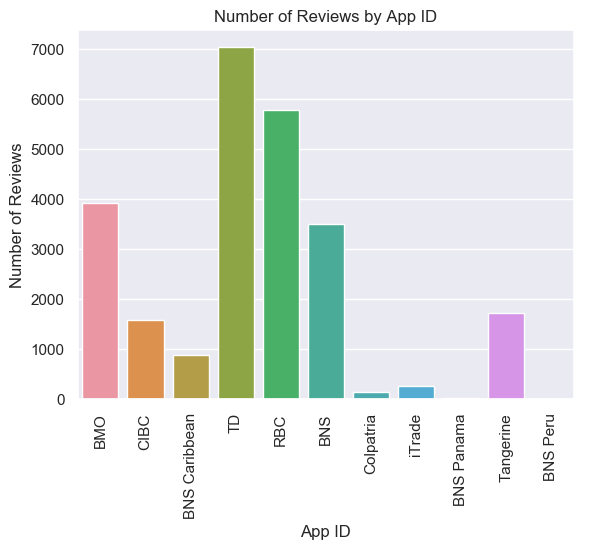

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
bx = sns.countplot(x = "AppID", data=df)
bx.set(xlabel='App ID', ylabel='Number of Reviews',title='Number of Reviews by App ID')
plt.xticks(rotation=90)
plt.show()

### Violin Plot: Ratings by App ID

> We can see that the TD app, and to a lesser degree the CIBC app, are very strong performer based on the proportion of app reviews clustering around the upper 5 point rating. Conversely, the iTrade, BNS Peru, and BNS Panama apps are heavily clustered around the lower rating. Another interesting observation is that there is a polarity in the reviews, where the ratings seemed to be clustered at the upper or lower spectrum of the rating scale. This may indicate that reviewers tend to feel strongly when they rate apps opting for either the excellent (5 star) or horrible (1 star) ratings. 

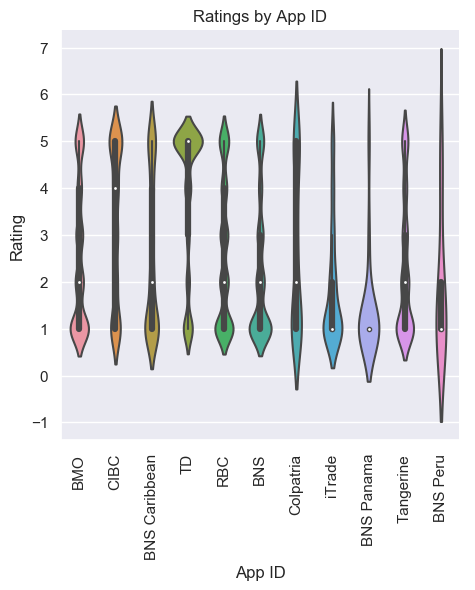

In [8]:
#Violin plot
sns.set(style="darkgrid")
cx = sns.catplot(x="AppID", y="Rating",
            kind="violin", data=df);
cx.set(xlabel='App ID', ylabel='Rating',title='Ratings by App ID')
plt.xticks(rotation=90)
plt.show()

### Stacked Plot: Percentage Proportion of Ratings by AppID
> Viewing the data as a stacked bar plot by percentage proportion of ratings let us see the observed trends more clearly. TD and CIBC, the two previously identified top performers, both have more than 50% of ratings in the positive range (>3-rating). The differentiating factor being that TD has more than 50% of reviews at the top tier 5-rating. The three lowest rating apps BNS Panama, BNS Peru, iTrade have more than 50% of review in the lowest tier 1-rating, and more than 70% of ratings lower than 3 stars. An unexpected observation is that all the apps, with the exception of TD and CIBC have more than 50% of the ratings in the negative range (<3-rating).  
 

In [9]:
#create unique list of names
Ratings = df.Rating.unique()
#Compose dictionary dataframe
PullRating = {elem : pd.DataFrame for elem in Ratings}
#create loop and define function
for key in PullRating.keys():
    PullRating[key] = (df[:][df.Rating == key].groupby('AppID').count())       
def give_rating(x):
    return list(PullRating[x].Rating)

In [10]:
#create count lists
r1 = give_rating(1)
r2 = give_rating(2)
r3 = give_rating(3)
r3.insert(4, 0)#need to insert zero for missing Peru
r4 = give_rating(4)
r4.insert(3, 0)#need to insert zero for missing Panama
r5 = give_rating(5)


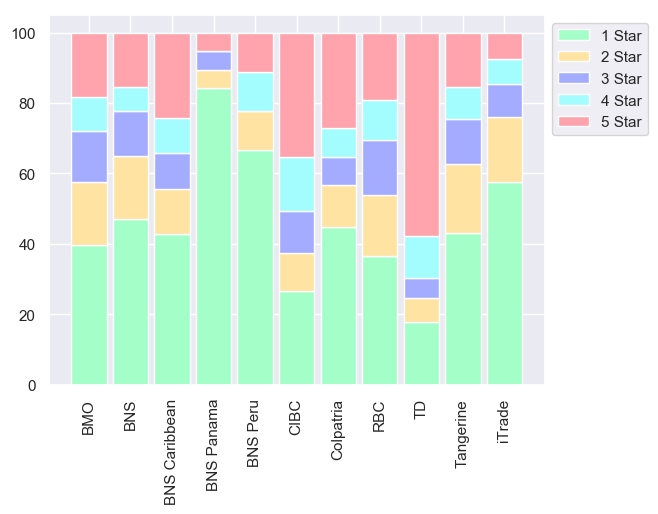

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# Data
r = [0,1,2,3,4,5,6,7,8,9,10]
combine = {'s1Bars': r1, 's2Bars': r2,'s3Bars': r3,'s4Bars': r4,'s5Bars': r5}
stack = pd.DataFrame(combine)
 
# Calculate percentage
totals = [i+j+k+l+m for i,j,k,l,m in zip(stack['s1Bars'], stack['s2Bars'], stack['s3Bars'], stack['s4Bars'], stack['s5Bars'])]
s1Bars = [i / j * 100 for i,j in zip(stack['s1Bars'], totals)]
s2Bars = [i / j * 100 for i,j in zip(stack['s2Bars'], totals)]
s3Bars = [i / j * 100 for i,j in zip(stack['s3Bars'], totals)]
s4Bars = [i / j * 100 for i,j in zip(stack['s4Bars'], totals)]
s5Bars = [i / j * 100 for i,j in zip(stack['s5Bars'], totals)]
 
# plot
barWidth = 0.85
names = ( 'BMO' ,'BNS' ,'BNS Caribbean' ,'BNS Panama' ,'BNS Peru' ,'CIBC' ,'Colpatria' ,'RBC' ,'TD' ,'Tangerine' ,'iTrade')
# Create s1 Bars
plt.bar(r, s1Bars, color='#a3ffc7', edgecolor='white', width=barWidth, label="1 Star")
# Create s2 Bars
plt.bar(r, s2Bars, bottom=s1Bars, color='#ffe3a3', edgecolor='white', width=barWidth, label="2 Star")
# Create s3 Bars
plt.bar(r, s3Bars, bottom=[i+j for i,j in zip(s1Bars, s2Bars)], color='#a3acff', edgecolor='white', width=barWidth, label="3 Star")
# Create s4 Bars
plt.bar(r, s4Bars, bottom=[i+j+k for i,j,k in zip(s1Bars, s2Bars, s3Bars)], color='#a3fdff', edgecolor='white', width=barWidth, label="4 Star")
# Create s5 Bars
plt.bar(r, s5Bars, bottom=[i+j+k+l for i,j,k,l in zip(s1Bars, s2Bars, s3Bars, s4Bars)], color='#ffa3ac', edgecolor='white', width=barWidth, label="5 Star")

#X-axis and legend
plt.xticks(r, names, rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.show()



### Table: Measure of Central Tendency (Median; Mean)
> The below tables view the mean and median ratings for each app as a measure of central tendency. The median validates the observations from the stacked plot, with TD and CIBC having a median rating of 5 and 4 respectively, and BNS Peru, BNS Panama and iTrade possessing median ratings of 1. Additionally, we can see that all the other apps have median ratings in the negative range (<3-rating). The measure of mean on ordinal data like ratings is controversial, but I believe the float value provides context to the median rating. Looking at the TD app, 5 stars would seem to indicate a near perfect app, but the mean rating of 3.85 shows us that there are significant negative ratings drawing down this score.


In [12]:
#create summary table for Mean and Median by AppID
table = df[['AppID','Rating']]
table = table.rename(columns={'Rating': 'median'})
table['mean']=df['Rating']
table = table.groupby('AppID').agg({'median':'median', 'mean':'mean'})
table = table.sort_values(['median','mean'],ascending=False)
print(table)

               median      mean
AppID                          
TD                  5  3.849169
CIBC                4  3.219187
Colpatria           2  2.610294
BNS Caribbean       2  2.600229
RBC                 2  2.591985
BMO                 2  2.489019
Tangerine           2  2.343423
BNS                 2  2.252854
BNS Peru            1  1.888889
iTrade              1  1.887218
BNS Panama          1  1.368421


### Plot: Distribution of Reviews by Rating

> Finally this plot view the distributions of reviews across all ratings. We can see that the number of positive and negative reviews are relatively similar, which may indicate that we can have a relatively high degree of confidence in the sentiment identified from this dataset.

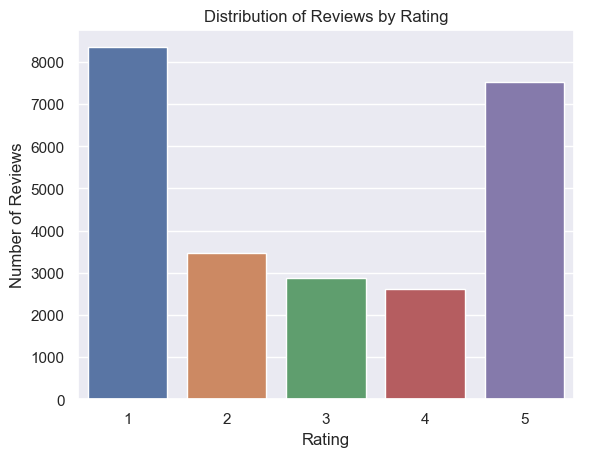

In [13]:
#dfr.groupby('Rating').count()
sns.set(style="darkgrid")
bx = sns.countplot(x = "Rating", data=df)
bx.set(xlabel='Rating', ylabel='Number of Reviews',title='Distribution of Reviews by Rating')
plt.show()

# Model Development and Analysis

To create the datasets used for our analysis, we first create two new dataframes. The first dataframe df_class will contain the reviews that can be defined as positive or negative (e.g. above or below 3). The second dataframe will contain ratings of 3, which are neutral or undefined.

In [14]:
#take lowest and highest rating
df_class = df[(df['Rating'] < 3) | (df['Rating'] > 3)]
df_neutral = df[(df['Rating'] == 3)]
df_class = df_class.sort_values(by=['Rating'])
print ("Dimenions:", df_class.shape)
df_class.groupby('Rating').count()

Dimenions: (21961, 4)


,Date,AppID,Reviews
Rating,,,
1,8351,8351,8351
2,3476,3476,3476
4,2614,2614,2614
5,7520,7520,7520


In [15]:

from sklearn.feature_extraction.text import CountVectorizer #create sparse matrix

cv = CountVectorizer(binary=True)
cv.fit(df_class['Reviews'])
X = cv.transform(df_class['Reviews'])
X_test = cv.transform(df_class['Reviews'])

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#target = [1 if i > 8352 else 0 for i in range(15872)]
target = [1 if i > 11827 else 0 for i in range(21961)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75 #change to 0.8
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
#     Accuracy for C=0.01: 0.87472
#     Accuracy for C=0.05: 0.88368
#     Accuracy for C=0.25: 0.88016
#     Accuracy for C=0.5: 0.87808
#     Accuracy for C=1: 0.87648

C:\Users\s2555246\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\s2555246\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.8612274631214715
Accuracy for C=0.05: 0.8896375887816427
Accuracy for C=0.25: 0.9011109087597887
Accuracy for C=0.5: 0.9027499544709525
Accuracy for C=1: 0.9007466763795301


In [17]:
#train model
final_model = LogisticRegression(C=0.5)
final_model.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))

Final Accuracy: 0.9345658212285415


In [18]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:15]:
    print (best_positive)

    
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:15]:
    print (best_negative)


('love', 2.966667397469526)
('awesome', 2.8967117608434267)
('great', 2.527588373747484)
('easy', 2.434767445927937)
('amazing', 2.42069735499061)
('excellent', 2.408831688461597)
('best', 2.2706314426005885)
('thank', 2.173317953725938)
('handy', 2.0982875681636552)
('perfect', 2.0660786940239215)
('good', 1.9306735983218213)
('finally', 1.797583364543361)
('convenient', 1.7590645544469363)
('thanks', 1.599037292211046)
('saves', 1.5899527758058443)
('worst', -2.545143015386732)
('sucks', -2.3057916809377805)
('terrible', -2.286117612847623)
('useless', -2.267095995404424)
('garbage', -2.177271607101879)
('horrible', -2.1431908350371636)
('disappointed', -1.9193128801386472)
('unreliable', -1.9140823645457024)
('crashes', -1.8914110370772832)
('slow', -1.891194335793664)
('cant', -1.844667691003108)
('frustrating', -1.803611435027721)
('hate', -1.6866253845292696)
('awful', -1.683827402265241)
('wont', -1.6401216969648382)


In [19]:
#import nltk
#nltk.download()

### Data Preparation and Cleaning: Text Transformations - FIX THIS

>The default setting for the lemmatization module of NLTK wordnet is ‘noun’. This caused the lemmatization to fail on earlier attempts to clean the text data. The below function defines the word type based on the position tag that will be assigned to each words using the pos_tag module from NLTK in the next clean_text function.


In [20]:
from nltk.corpus import wordnet

def get_tag(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

The clean_text function defined below applies the following transformations: <br>
> 1) Changes all words to lower case (lemmatization does not work on capitals as they are assumed to be proper nouns). <br>
> 2) Tokenize the text and remove punctuation. <br>
> 3) Remove numeric values. <br>
> 4) Remove stop words (using pre-built stop word dictionary). <br>
> 5) Remove any empty tokens. <br> 
> 6) Apply a position tag to each word and defines it based on the previously defined get_tag function as adjective, noun, verb, or adverb.<br>
> 7) Lemmatize the words. <br>
> 8) Remove any single letter words resulting from lemmatization.<br>

In [21]:

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    text = text.lower() #change all text to lower case
    text = [word.strip(string.punctuation) for word in text.split(" ")] #tokenize and remove punctuation
    text = [word for word in text if not any(c.isdigit() for c in word)] #remove numeric values
    stop = stopwords.words('english') #call english stop word dictionary
    text = [x for x in text if x not in stop]#remove stop words
    text = [t for t in text if len(t) > 0] #remove empty tokens
    pos_tags = pos_tag(text)#apply position tag to text
    text = [WordNetLemmatizer().lemmatize(t[0], get_tag(t[1])) for t in pos_tags] #apply pos_tag function and lemmatize text
    text = [t for t in text if len(t) > 1]# remove single letter words
    text = " ".join(text) #combine
    return(text)
#create new column with cleaned text
df_class["reviews_clean"] = df_class["Reviews"].apply(lambda x: clean_text(x))

Just a quick preview of the results:

In [22]:
print('Before Text Cleaning')
df_class['Reviews'].head()

Before Text Cleaning


1        great app other than check your credit score n...
20555    Can u please!!!! Fix this. I am tired of putti...
20553    There's a pop-up saying that I have been signe...
9882                It's junk and won't work on Samsung a5
9884                                  Td my bank of choice
Name: Reviews, dtype: object

In [23]:
print('After Text Cleaning')
df_class['reviews_clean'].head()

After Text Cleaning


1                      great app check credit score update
20555              please fix tire put longggg number time
20553    there's pop-up say sign inactivity app let sig...
9882                                     junk work samsung
9884                                        td bank choice
Name: reviews_clean, dtype: object

## Feature Engineering

### Sentiment Analysis

>The Vader module from NLTK was the model selected for sentiment analysis. The Vader module uses a prebuilt lexicon of words and the context of the sentences to calculate a sentiment score. The module returns 4 values: positivity score, neutrality score, negativity score and summary score.


In [ ]:
sid = SentimentIntensityAnalyzer()
#calculates the negativity,  neutrality, positivity and overall sentiment scores
df_neutral["sentiments"] = df_neutral["reviews_clean"].apply(lambda x: sid.polarity_scores(x))
#drop sentiment column and add the 4 sentiment scores as separate features to primary dataset
df_neutral = pd.concat([df_neutral.drop(['sentiments'], axis=1), df_class['sentiments'].apply(pd.Series)], axis=1)
df_class

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
#calculates the negativity,  neutrality, positivity and overall sentiment scores
df_class["sentiments"] = df_class["reviews_clean"].apply(lambda x: sid.polarity_scores(x))
#drop sentiment column and add the 4 sentiment scores as separate features to primary dataset
df_class = pd.concat([df_class.drop(['sentiments'], axis=1), df_class['sentiments'].apply(pd.Series)], axis=1)
df_class

,Date,AppID,Rating,Reviews,reviews_clean,neg,neu,pos,compound
1,2019-01-28,CIBC,1,great app other than check your credit score n...,great app check credit score update,0.000,0.374,0.626,0.7717
20555,2016-06-21,RBC,1,Can u please!!!! Fix this. I am tired of putti...,please fix tire put longggg number time,0.000,0.581,0.419,0.3818
20553,2016-06-21,RBC,1,There's a pop-up saying that I have been signe...,there's pop-up say sign inactivity app let sig...,0.153,0.847,0.000,-0.4019
9882,2018-02-23,TD,1,It's junk and won't work on Samsung a5,junk work samsung,0.000,1.000,0.000,0.0000
9884,2018-02-23,TD,1,Td my bank of choice,td bank choice,0.000,1.000,0.000,0.0000
20549,2016-06-22,RBC,1,Sick of having to look for my card extremely i...,sick look card extremely inconvenient fix alre...,0.500,0.500,0.000,-0.7178
20548,2016-06-22,RBC,1,I hate rbc,hate rbc,0.787,0.213,0.000,-0.5719
20547,2016-06-22,RBC,1,The direct investing part of the app is very b...,direct invest part app break particularly trad...,0.150,0.728,0.121,-0.1531
9888,2018-02-23,TD,1,Don't know what any of this is. Why I'm FORCE...,know i'm force something idea i'm banking,0.000,1.000,0.000,0.0000
9889,2018-02-23,BMO,1,Previous version was 100 times better....this ...,previous version time better....this current v...,0.216,0.597,0.187,-0.1027


In [25]:
df_class

,Date,AppID,Rating,Reviews,reviews_clean,neg,neu,pos,compound
1,2019-01-28,CIBC,1,great app other than check your credit score n...,great app check credit score update,0.000,0.374,0.626,0.7717
20555,2016-06-21,RBC,1,Can u please!!!! Fix this. I am tired of putti...,please fix tire put longggg number time,0.000,0.581,0.419,0.3818
20553,2016-06-21,RBC,1,There's a pop-up saying that I have been signe...,there's pop-up say sign inactivity app let sig...,0.153,0.847,0.000,-0.4019
9882,2018-02-23,TD,1,It's junk and won't work on Samsung a5,junk work samsung,0.000,1.000,0.000,0.0000
9884,2018-02-23,TD,1,Td my bank of choice,td bank choice,0.000,1.000,0.000,0.0000
20549,2016-06-22,RBC,1,Sick of having to look for my card extremely i...,sick look card extremely inconvenient fix alre...,0.500,0.500,0.000,-0.7178
20548,2016-06-22,RBC,1,I hate rbc,hate rbc,0.787,0.213,0.000,-0.5719
20547,2016-06-22,RBC,1,The direct investing part of the app is very b...,direct invest part app break particularly trad...,0.150,0.728,0.121,-0.1531
9888,2018-02-23,TD,1,Don't know what any of this is. Why I'm FORCE...,know i'm force something idea i'm banking,0.000,1.000,0.000,0.0000
9889,2018-02-23,BMO,1,Previous version was 100 times better....this ...,previous version time better....this current v...,0.216,0.597,0.187,-0.1027


### Feature engineering

> Create two new features: the number of characters per column and number of words per column.

In [26]:
df_class["num_chars"] = df_class["reviews_clean"].apply(lambda x: len(x))
df_class["num_words"] = df_class["reviews_clean"].apply(lambda x: len(x.split(" ")))

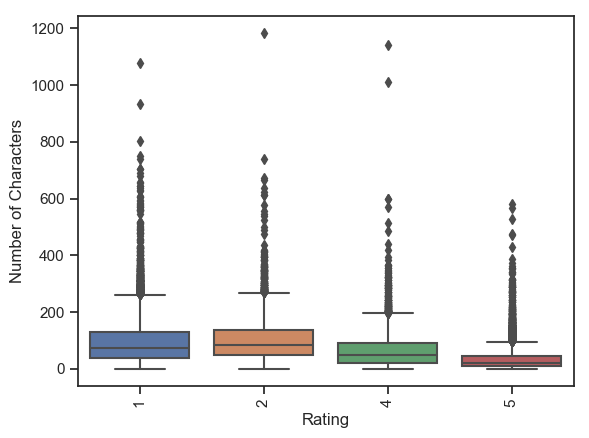

In [27]:

#Boxplot: Identify outliers

sns.set_style('ticks')
plt.xticks(rotation=90)
g = sns.boxplot(data = df_class,x = 'Rating', y = 'num_chars')
g.set(xlabel='Rating', ylabel='Number of Characters',title='')
plt.show()

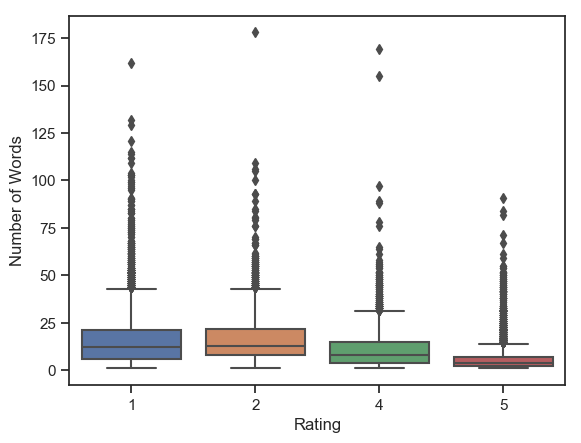

In [28]:
g = sns.boxplot(data = df_class,x = 'Rating', y = 'num_words')
g.set(xlabel='Rating', ylabel='Number of Words',title='')
plt.show()

In [29]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_class["reviews_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
df_vector = df_class["reviews_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
df_vector.columns = ["df_vector_" + str(x) for x in df_vector.columns]
df_class = pd.concat([df_class, df_vector], axis=1)

C:\Users\s2555246\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [30]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df_class["reviews_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df_class.index
df_class = pd.concat([df_class, tfidf_df], axis=1)

In [31]:
# show is_bad_review distribution
df_class["Rating"].value_counts(normalize = True)

1    0.380265
5    0.342425
2    0.158281
4    0.119029
Name: Rating, dtype: float64

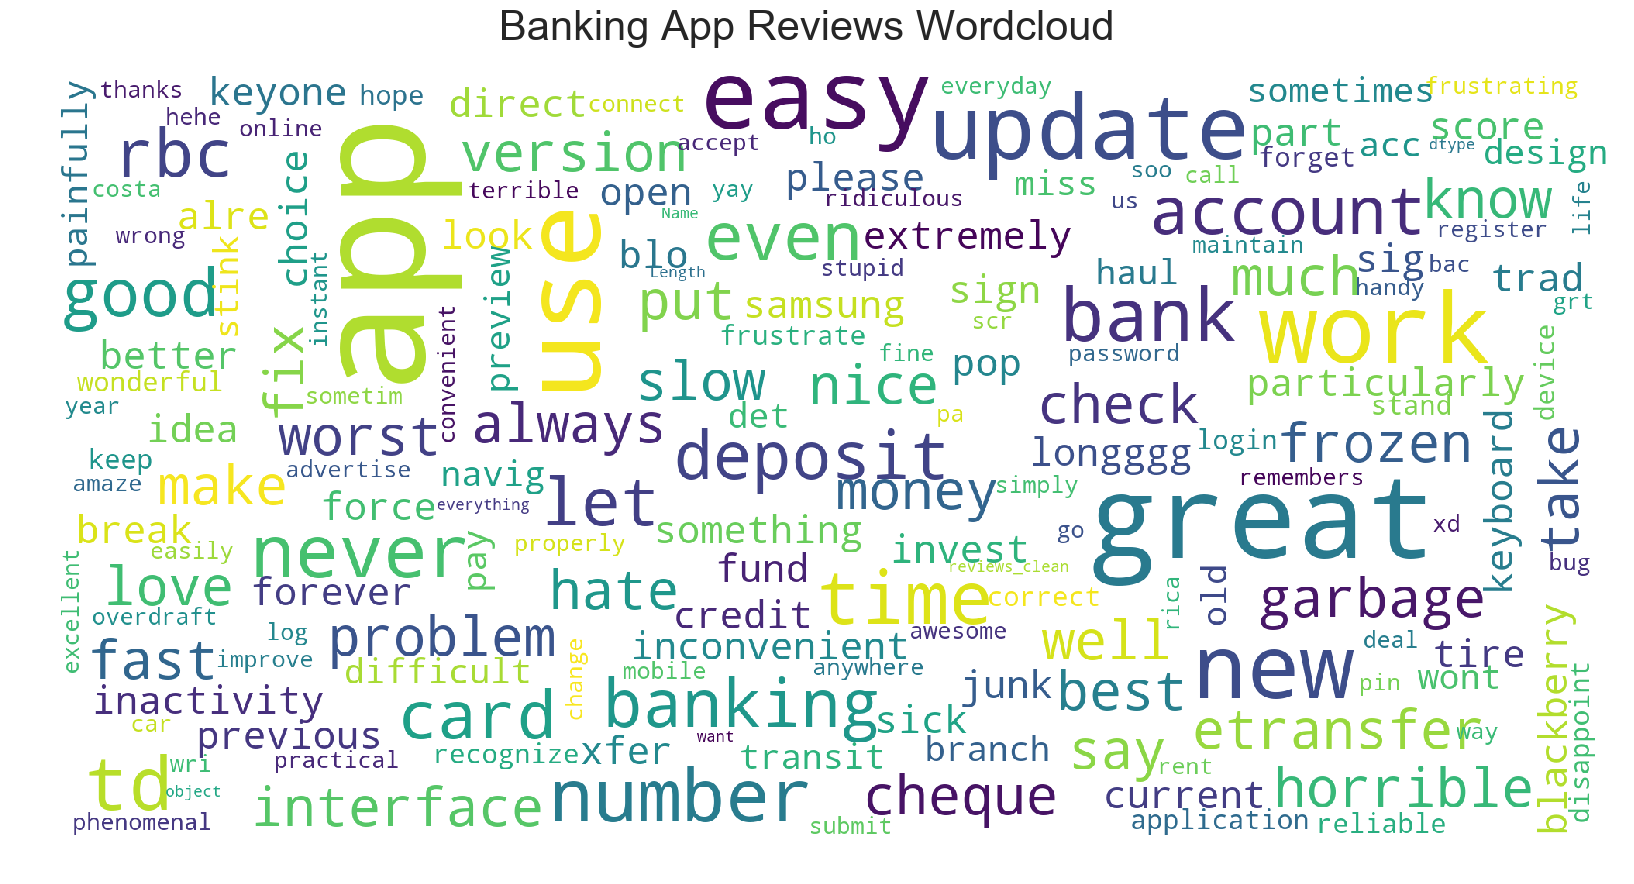

In [32]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = 'Banking App Reviews Wordcloud'):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 5,
        random_state = 52
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 30)
        fig.subplots_adjust(top = 1.4)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df_class["reviews_clean"])

In [33]:
## # highest positive sentiment reviews (with more than 5 words)
#df_highest = df_class[df_class["nb_words"] >= 5].sort_values("pos", ascending = False)[["reviews_clean", "pos"]].head(20)
df_highest = df_class[df_class["num_words"] >=8].sort_values("pos", ascending = False)[["reviews_clean", "pos"]].head(20)
df_highest['reviews_clean']

6703      app amaze easy use definitely star worthy \nlove
13214    awesome convenient satisfy td canada trust tha...
2963       love monitor credit rating well app great thank
6378     super fast super secure super easy convenient ...
8796     love super easy save trip bank love thank td a...
381      excellent banking app clean interface user fri...
14562    good service cibc good staff good customer sup...
7604      easy use user friendly love mobile deposit great
2573          deposit cheque td app amazing great easy fun
11297         love app user friendly easy use perfect need
14640           great app super easy use make banking easy
14106    great app nice eye practical great safety feature
3302                  good app easy use save time love app
3862          awesome user friendly easy use good job keep
16858      great easy use app nice interface user friendly
6285     theyre quick friendly also super useful thank ...
4959     great app great bank incredibly easy navigate .

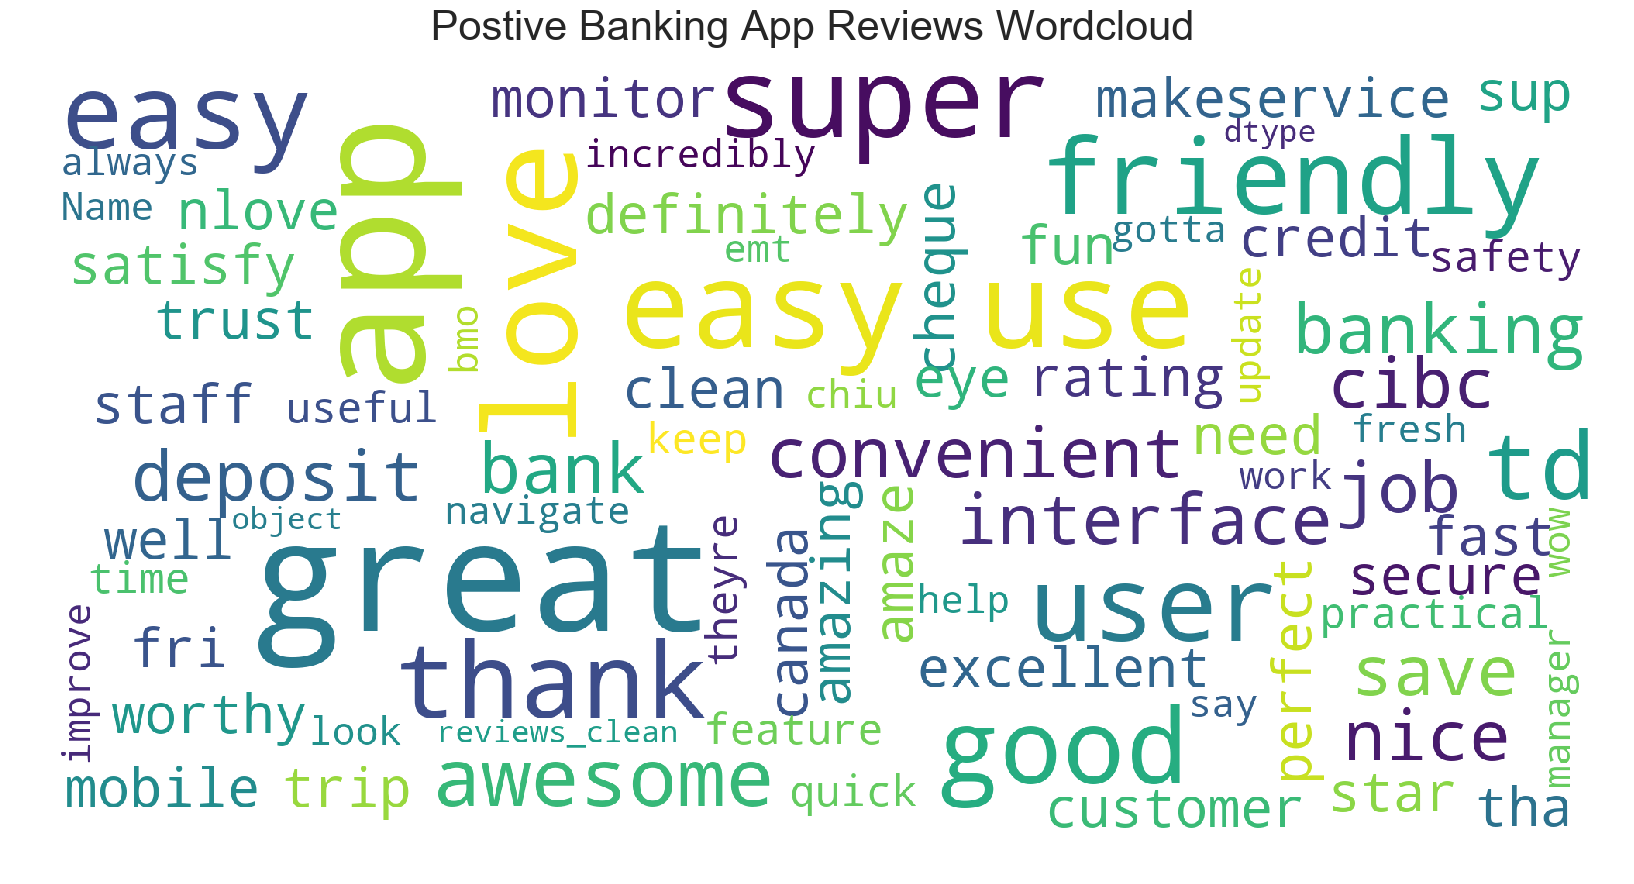

In [34]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = ' Postive Banking App Reviews Wordcloud'):
    wordcloud = WordCloud(
        background_color = 'White',
        max_words = 200,
        max_font_size = 40, 
        scale = 5,
        random_state = 52
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 30)
        fig.subplots_adjust(top = 1.4)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df_highest["reviews_clean"])

In [35]:
# lowest negative sentiment reviews (with more than 5 words)
df_lowest = df_class[df_class["nb_words"] >= 100].sort_values("neg", ascending = False)[["reviews_clean", "neg"]].head(10)


KeyError: 'nb_words'

In [ ]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = 'Negative Banking App Reviews Wordcloud'):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 5,
        random_state = 52
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 30)
        fig.subplots_adjust(top = 1.4)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df_lowest["reviews_clean"])

In [ ]:
import seaborn as sns

for x in [1, 5]:
    subset = df_class[df_class['Rating'] == x]
    # Draw the density plot
    if x > 3:
        label = "Postive Review"
    else:
        label = "Negative Review"    
  
    sns.distplot(subset['compound'], hist = False, label = label)
    



In [ ]:
#Revising our model to see if cleaning has improved accuracy

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(df_class['reviews_clean'])
X = cv.transform(df_class['reviews_clean'])
X_test = cv.transform(df_class['reviews_clean'])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#target = [1 if i > 8352 else 0 for i in range(15872)]
target = [1 if i > 12828 else 0 for i in range(21962)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
#     Accuracy for C=0.01: 0.87472
#     Accuracy for C=0.05: 0.88368
#     Accuracy for C=0.25: 0.88016
#     Accuracy for C=0.5: 0.87808
#     Accuracy for C=1: 0.87648

In [ ]:
#train model
final_model = LogisticRegression(C=0.25)
final_model.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))

In [ ]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:10]:
    print (best_positive)
    
#     ('excellent', 0.9288812418118644)
#     ('perfect', 0.7934641227980576)
#     ('great', 0.675040909917553)
#     ('amazing', 0.6160398142631545)
#     ('superb', 0.6063967799425831)
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    print (best_negative)
    
#     ('worst', -1.367978497228895)
#     ('waste', -1.1684451288279047)
#     ('awful', -1.0277001734353677)
#     ('poorly', -0.8748317895742782)
#     ('boring', -0.8587249740682945)

In [ ]:
df_class

In [ ]:
def good_bad(r):
    if (r < 3):
        return 1
    else:
        return 0
    
df_class['bad_review'] = df_class['Rating'].apply(good_bad)

In [ ]:
df_class['bad_review'] = df_class['Rating'].apply(good_bad)

In [ ]:
df_class

In [ ]:
# feature selection
label = "bad_review"
ignore_cols = [label, "Reviews", "reviews_clean", "Date", "AppID","Rating"]
features = [c for c in df_class.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_class[features], df_class[label], test_size = 0.20, random_state = 42)


In [ ]:

# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

In [ ]:

# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:

# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
# load in all the modules we're going to need
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams

In [ ]:
#CREATE DIFFERENT TOKENIZE FIELDS
#df_class = df[(df['Rating'] < 3) | (df['Rating'] > 3)]
tokenized = df_class["reviews_clean"].apply(lambda x: x.split())


In [ ]:
import pandas as pd
from nltk.collocations import *
import nltk.collocations
from nltk import ngrams
from collections import Counter

finder = BigramCollocationFinder.from_documents(tokenized.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()

# only bigrams that appear 1+ times
finder.apply_freq_filter(1) 

# return the 10 n-grams with the highest PMI
result = finder.nbest(bigram_measures.pmi, 10)

ngram_list = [pair for row in tokenized for pair in ngrams(row, 5)]

counts = Counter(ngram_list).most_common()

pd.DataFrame.from_records(counts, columns=['gram', 'count']).head(25)

## PLAYGROUND

In [299]:
import re

def generate_ngrams(s, n):
    # Convert to lowercases
    s = s.lower()
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    
    # Break sentence in the token, remove empty tokens
    tokens = [tokenize for tokenize in s.split(" ") if tokenize != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [300]:
bigrams = df_class['reviews_clean'].apply(lambda x: generate_ngrams(x,n=2))

In [301]:
counts = collections.Counter()
for sent in df_highest['reviews_clean']:
    words = nltk.word_tokenize(sent)
    counts.update(nltk.bigrams(words))
    
counts